<a href="https://colab.research.google.com/github/lqdungx/TTNT/blob/main/CelebA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# --- Cài đặt thư viện ---
!pip install torch torchvision matplotlib --quiet

import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [3]:
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # ảnh RGB [-1,1]
])
dataset = datasets.CelebA(root="./data", split="train",
                          transform=transform, download=True)
loader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)


Downloading...
From (original): https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM
From (redirected): https://drive.usercontent.google.com/download?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM&confirm=t&uuid=13bc819f-8494-4f07-8587-2ab5288412c6
To: /content/data/celeba/img_align_celeba.zip
100%|██████████| 1.44G/1.44G [00:18<00:00, 78.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pblRyaVFSWGxPY0U
To: /content/data/celeba/list_attr_celeba.txt
100%|██████████| 26.7M/26.7M [00:00<00:00, 105MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1_ee_0u7vcNLOfNLegJRHmolfH5ICW-XS
To: /content/data/celeba/identity_CelebA.txt
100%|██████████| 3.42M/3.42M [00:00<00:00, 32.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pbThiMVRxWXZ4dU0
To: /content/data/celeba/list_bbox_celeba.txt
100%|██████████| 6.08M/6.08M [00:00<00:00, 66.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=0B7EVK8r0v71pd0FJY3Blby1HUTQ
To: /content/data/celeba/list_landm

In [4]:
# Generator
class Generator(nn.Module):
    def __init__(self, z_dim=100, img_channels=3, features_g=64):
        super().__init__()
        self.net = nn.Sequential(
            self.block(z_dim, features_g*8, 4, 1, 0),
            self.block(features_g*8, features_g*4, 4, 2, 1),
            self.block(features_g*4, features_g*2, 4, 2, 1),
            self.block(features_g*2, features_g,   4, 2, 1),
            nn.ConvTranspose2d(features_g, img_channels, 4, 2, 1),
            nn.Tanh()
        )
    def block(self, in_c, out_c, k, s, p):
        return nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, k, s, p, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU(True)
        )
    def forward(self, x): return self.net(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, img_channels=3, features_d=64):
        super().__init__()
        self.net = nn.Sequential(
            self.block(img_channels, features_d, 4, 2, 1, False),
            self.block(features_d, features_d*2, 4, 2, 1),
            self.block(features_d*2, features_d*4, 4, 2, 1),
            self.block(features_d*4, features_d*8, 4, 2, 1),
            nn.Conv2d(features_d*8, 1, 4, 1, 0),
            nn.Sigmoid()
        )
    def block(self, in_c, out_c, k, s, p, bn=True):
        layers = [nn.Conv2d(in_c, out_c, k, s, p, bias=False)]
        if bn: layers.append(nn.BatchNorm2d(out_c))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        return nn.Sequential(*layers)
    def forward(self, x): return self.net(x)


Epoch done | Loss_D: 1.1453 | Loss_G: 1.9267


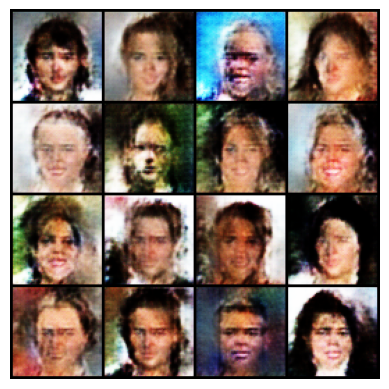

In [5]:
z_dim = 100
G = Generator(z_dim).to(device)
D = Discriminator().to(device)
opt_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5,0.999))
opt_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5,0.999))
criterion = nn.BCELoss()

for epoch in range(1):  # demo 1 epoch
    for real, _ in loader:
        real = real.to(device)
        bs = real.size(0)
        # Train Discriminator
        noise = torch.randn(bs, z_dim, 1, 1, device=device)
        fake = G(noise)
        loss_D = (criterion(D(real), torch.ones(bs,1,1,1,device=device)) +
                  criterion(D(fake.detach()), torch.zeros(bs,1,1,1,device=device))) / 2
        opt_D.zero_grad(); loss_D.backward(); opt_D.step()
        # Train Generator
        loss_G = criterion(D(fake), torch.ones(bs,1,1,1,device=device))
        opt_G.zero_grad(); loss_G.backward(); opt_G.step()
    print(f"Epoch done | Loss_D: {loss_D.item():.4f} | Loss_G: {loss_G.item():.4f}")

# Sinh thử ảnh
noise = torch.randn(16, z_dim, 1, 1, device=device)
samples = G(noise).cpu().detach()
grid = torchvision.utils.make_grid(samples, nrow=4, normalize=True)
plt.imshow(grid.permute(1,2,0))
plt.axis("off")
plt.show()
